## Microbusiness Density Forecasting using Statistical Models

#### Univariate models like ARIMA or prophet can be used to forecasting Microbusiness Density provided we convert the dataset into a univariate data, i.e, data with only time-series variable and target variable

### Install Packages

### Import Required Libraries

In [168]:
# Import required libraries
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from prophet import Prophet
from tqdm import tqdm

from plotly.subplots import make_subplots

In [169]:
import warnings
warnings.filterwarnings("ignore")


In [170]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Data

In [171]:
df_train = pd.read_csv("drive/MyDrive/DS5500/train.csv")
df_test = pd.read_csv("drive/MyDrive/DS5500/test.csv")

### EDA


* The essential step needed to perform forecasting using univariate models is populating the "time-series" datatype object from the string representation of date column. 
* We will group the density values per month across all the counties so that we will endup with 39 rows of data where each row corresponds to the Microbusiness Density for a given month. 


In [172]:
df_train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [173]:
# Convert to datetime
df_train['first_day_of_month'] = pd.to_datetime(df_train['first_day_of_month'], format = "%Y-%m-%d")

In [174]:
# Rename the columns
df_renamed = df_train[['first_day_of_month', 'microbusiness_density']]
df_renamed.rename(columns = {'first_day_of_month':'date', 'microbusiness_density':'density',}, inplace = True)
df_renamed.head()

# Group by month
df_grouped = df_renamed.groupby('date')['density'].mean().reset_index()
df_grouped.head()

,date,density
0,2019-08-01,3.749621
1,2019-09-01,3.696846
2,2019-10-01,3.778263
3,2019-11-01,3.722510
4,2019-12-01,3.717284


Text(0.5, 1.0, 'Monthly Microbusiness Density')

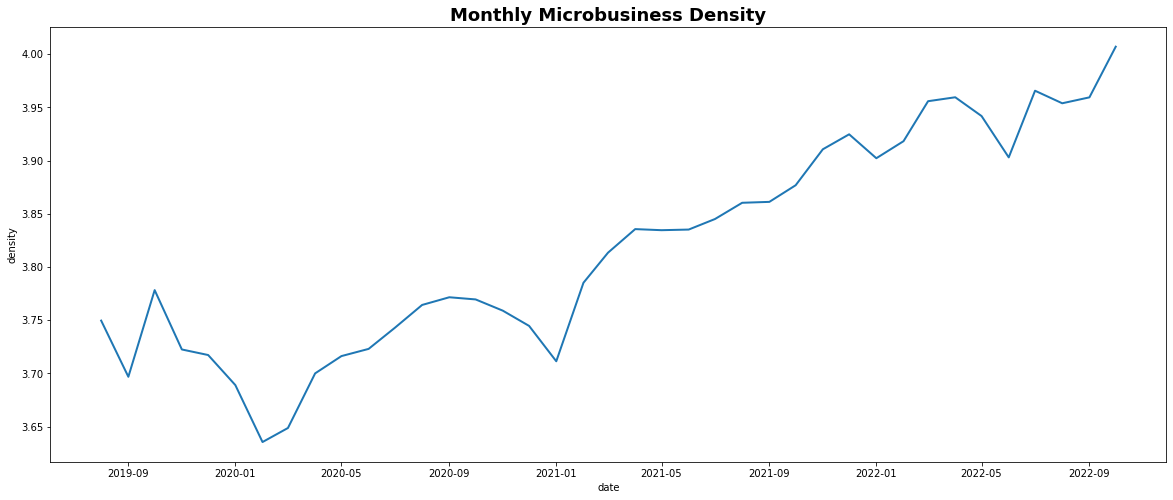

In [175]:
# Plot the graph
fig = plt.figure(figsize = (20, 8))
sns.lineplot(x = df_grouped['date'], y= df_grouped['density'], linewidth=2, )
plt.title("Monthly Microbusiness Density",
          fontsize = 18,
          fontweight = 'bold',
          fontfamily = 'Helvetica',
          loc = 'center')


*Data doesn't appear to be Seasonal**

#### Running the Statistical Model

**Approach 1:** We will train an ARIMA model on the grouped data and try to forecast the Microbusiness Density for the upcoming months

We will use a library called Auto-ARIMA to perform hyperparameter tuning and determine the "p", "d", "q" variables that determine an ARIMA model. In an ARIMA (AutoRegressive Integrated Moving Average) model, "p", "d", and "q" are parameters that represent different components of the model:

* "p" is the order of the Autoregression(AR) term. It represents the number of lagged values of the time series used to explain the current value.

* "d" is the degree of differencing(I). It represents the number of times the time series has been difference to make it stationary.

* "q" is the order of the moving average term (MA). It represents the number of lagged forecast errors used to explain the current value.

The combination of these three parameters (p, d, q) defines the structure of the ARIMA model, which is used to make predictions about future values of the time series based on past values.

**Let's run the ADF test to determine if the data is stationary**

Augmented Dicky Fuller Test

In [176]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_grouped['density'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.176712
p-value: 0.941241
Critical Values:
	1%: -3.616
	5%: -2.941
	10%: -2.609


Here we can see that the p-value is more than 0.05 this means our null hypothesis will not be rejected and we will take this series as non-stationary.  


We need to determine the differencing term. The simplest way to do this is differencing the data directly using Pandas for different orders and plot the data

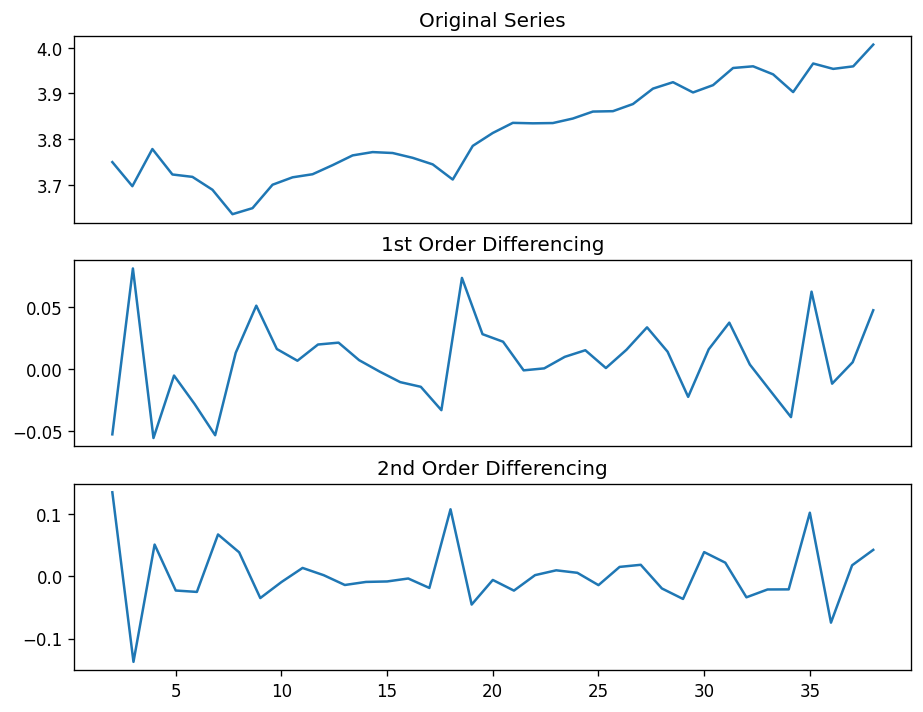

In [177]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_grouped.density); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_grouped.density.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_grouped.density.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

The first order differencing appears to be stationary, so d can be set as 1

There are methods to determine "p" and "q" but we will use a popular framework called Auto-ARIMA to select the best p and q values.

In [178]:
model_fit = auto_arima(df_grouped['density'],
                       test='adf',
                       d=1,
                       D=1,
                       start_p=0,
                       start_q=0,
                       max_order=None,                       
                       max_p=10,
                       max_q=10,
                       max_d=5,
                       max_P=10,
                       max_Q=10,
                       max_D=10,
                       maxiter = 50,
                       alpha = 0.05,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True, 
                       stepwise=True
                      )

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-149.745, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-149.279, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-149.488, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-150.080, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-149.229, Time=0.29 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.437 seconds


The p, d, q values are 0, 1 and 0 respectively.

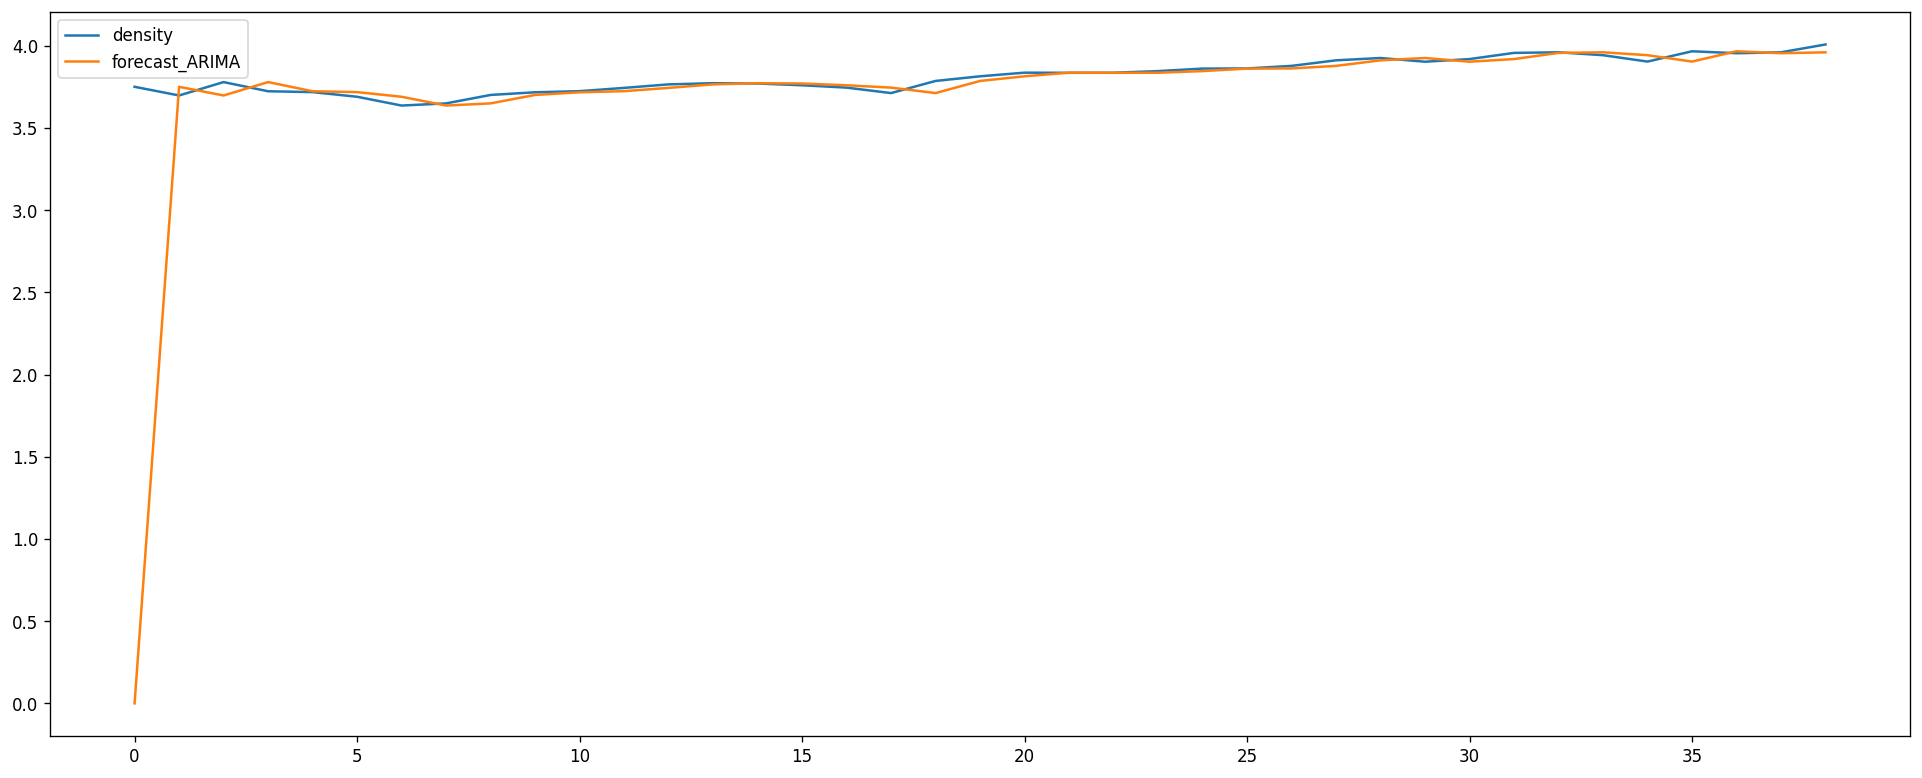

In [179]:

model_ARIMA = ARIMA(df_grouped['density'],
              order=(0,1,0),
              seasonal_order=(0, 0, 0, 0),
            )


model_ARIMA = model_ARIMA.fit()

df_grouped['forecast_ARIMA'] = model_ARIMA.predict()
df_grouped[['density','forecast_ARIMA']].plot(figsize=(20,8))

# Prophet Baseline Model

In Approach 1, we grouped the time-series data by months and didn't account for each individual counties within the Mainland US. We will try to forecast for each county using Prophet.

**Approach 2:** In this approach we will build separate univariate models for each county for 39 months of data.

In [180]:
# Garbage collection
import gc
gc.collect()

14961

In [181]:
# Column types
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   row_id                 122265 non-null  object        
 1   cfips                  122265 non-null  int64         
 2   county                 122265 non-null  object        
 3   state                  122265 non-null  object        
 4   first_day_of_month     122265 non-null  datetime64[ns]
 5   microbusiness_density  122265 non-null  float64       
 6   active                 122265 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 6.5+ MB


In [182]:
# Plot the time series for some of the counties 
num_plots = 5
fig = make_subplots(rows=num_plots, cols=1,
                   subplot_titles=(df_train.groupby('cfips').head(1)['cfips'].iloc[:num_plots].to_list()))

for idx, cfip in enumerate(df_train['cfips'].unique()[:num_plots]):
    
    fig.append_trace(go.Scatter(
    x=df_train['first_day_of_month'].loc[df_train['cfips'] == cfip],
    y=df_train['microbusiness_density'].loc[df_train['cfips'] == cfip],
    name=str(df_train['county'].loc[df_train['cfips'] == cfip].tail(1).values[0]) +\
        ', ' + str(df_train['state'].loc[df_train['cfips'] == cfip].tail(1).values[0])    
    ), row=idx+1, col=1)


fig.update_layout(template="simple_white", font=dict(size=18), width=1000, height=1400)
fig.show()

In [183]:
# Prophet requires a dataframe with 'ds': date and 'y': the series
df_train.rename(columns={'first_day_of_month':'ds' }, inplace=True)
df_train.head()

,row_id,cfips,county,state,ds,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [184]:

# We add a small delta to 0's to perform the transformation
df_train['microbusiness_density'].replace({0:0.0000001}, inplace=True)

# Ensure target is names 'y' as prophet requries
df_train['y'], lam = boxcox(df_train['microbusiness_density'])
df_train.head()

,row_id,cfips,county,state,ds,microbusiness_density,active,y
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,1.152025
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,1.106504
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,1.169412
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,1.146759
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,1.146759


In [185]:
# Add the target placeholder on test dataset
df_test['microbusiness_density'] = 0
df_test.head()

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,0
1,1003_2022-11-01,1003,2022-11-01,0
2,1005_2022-11-01,1005,2022-11-01,0
3,1007_2022-11-01,1007,2022-11-01,0
4,1009_2022-11-01,1009,2022-11-01,0


At first we attempted to run this model on all the Unique counties but that is computationally expensive as it means we need to run as many Prophet models as there are counties in the data

In [186]:
len(df_train['cfips'].unique())

3135

Assuming it takes about 5 seconds to fit one prophet model, we will need to initialize and fit prophet model for 3135 counties which would take about (3135 * 5secs) = 15, 675 secs = 4.35 hours 

In [187]:
# Hence we reduce the scope to first 50 counties 
num_counties = 50

for cfip in tqdm(df_train['cfips'].unique()[:num_counties]):
    
    model = Prophet(weekly_seasonality=False,
                    yearly_seasonality=False,
                    daily_seasonality=False,
                    n_changepoints=10,
                    changepoint_prior_scale=0.5,
                    growth='linear')
        
    # Fit model for the county
    model.fit(df_train[['ds', 'y']].loc[df_train['cfips'] == cfip])
        
    # Get the predictions and stores them in the dataframe       
    future = model.make_future_dataframe(periods=8, freq='MS')    
    forecasts = model.predict(future)    
    acc_forecasts = inv_boxcox(forecasts['yhat'].tail(8), lam) 
    df_test['microbusiness_density'].loc[df_test['cfips'] == cfip] = acc_forecasts.values

  0%|          | 0/50 [00:00<?, ?it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/s80h9zj1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/3_qghktu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13369', 'data', 'file=/tmp/tmp77h6qh99/s80h9zj1.json', 'init=/tmp/tmp77h6qh99/3_qghktu.json', 'output', 'file=/tmp/tmp77h6qh99/prophet_modelhbm96fyp/prophet_model-20230215060239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:02:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:02:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
  2%|▏         | 1/50 [00:00<00:08,  5.98it/s]DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/vzwci8ha.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/wz2xsjsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmds

In [188]:
# Let's see how the forecast looks like at county level for first 10 counties.

num_plots = 10
fig = make_subplots(rows=num_plots, cols=1,
                   subplot_titles=(df_train.groupby('cfips').head(1)['cfips'].iloc[:num_plots].to_list()))

for idx, cfip in enumerate(df_train['cfips'].unique()[:num_plots]):
    
    fig.append_trace(go.Scatter(
    x=df_train['ds'].loc[df_train['cfips'] == cfip],
    y=df_train['microbusiness_density'].loc[df_train['cfips'] == cfip],    
    name='Train',
    line=dict(color="blue", width=2)), row=idx+1, col=1)
    
    fig.append_trace(go.Scatter(
    x=df_test['first_day_of_month'].loc[df_test['cfips'] == cfip],
    y=df_test['microbusiness_density'].loc[df_test['cfips'] == cfip],    
    name='Forecast',
    line=dict(color="red", width=2)), row=idx+1, col=1)
    
names = set()
fig.for_each_trace(
    lambda trace:
    trace.update(showlegend=False)
    if (trace.name in names) else names.add(trace.name))

fig.update_layout(template="simple_white", font=dict(size=18), width=900, height=1500)
fig.show()

In [189]:
# View predictions for the first 50 counties
df_test.head(50)

,row_id,cfips,first_day_of_month,microbusiness_density
0,1001_2022-11-01,1001,2022-11-01,3.480131
1,1003_2022-11-01,1003,2022-11-01,8.652511
2,1005_2022-11-01,1005,2022-11-01,1.247961
3,1007_2022-11-01,1007,2022-11-01,1.325274
4,1009_2022-11-01,1009,2022-11-01,1.850273
5,1011_2022-11-01,1011,2022-11-01,1.011174
6,1013_2022-11-01,1013,2022-11-01,2.387705
7,1015_2022-11-01,1015,2022-11-01,2.819291
8,1017_2022-11-01,1017,2022-11-01,1.521301
9,1019_2022-11-01,1019,2022-11-01,1.106902


## Performance Evaluation

It's impossible to evaluate the performance on the test set as we don't have a ground truth value to compare with since it's an active competition on Kaggle. Instead we could evaluate the performance by comparing it against the ground truth on a train - test split for one of the counties. 

In [190]:
df_sample = df_train.loc[df_train['cfips'] == 1001] 

In [191]:
split = 0.8

test_index = int(round(39 * split))

train_set = df_sample[:test_index]
test_set = df_sample[test_index:]

In [192]:
# Let the forecasts be 0 for now
test_set["y_hat"] = 0

test_set

,row_id,cfips,county,state,ds,microbusiness_density,active,y,y_hat
31,1001_2022-03-01,1001,Autauga County,Alabama,2022-03-01,3.336785,1418,1.266081,0
32,1001_2022-04-01,1001,Autauga County,Alabama,2022-04-01,3.372082,1433,1.277693,0
33,1001_2022-05-01,1001,Autauga County,Alabama,2022-05-01,3.313253,1408,1.258277,0
34,1001_2022-06-01,1001,Autauga County,Alabama,2022-06-01,3.346197,1422,1.269189,0
35,1001_2022-07-01,1001,Autauga County,Alabama,2022-07-01,3.437971,1461,1.299074,0
36,1001_2022-08-01,1001,Autauga County,Alabama,2022-08-01,3.423852,1455,1.294524,0
37,1001_2022-09-01,1001,Autauga County,Alabama,2022-09-01,3.442677,1463,1.300586,0
38,1001_2022-10-01,1001,Autauga County,Alabama,2022-10-01,3.463856,1472,1.307370,0


In [193]:
model = Prophet(weekly_seasonality=False,
                  yearly_seasonality=False,
                  daily_seasonality=False,
                  n_changepoints=10,
                  changepoint_prior_scale=0.5,
                  growth='linear')
      
# Fit model for the county 1001
model.fit(train_set[['ds', 'y']])

# Get the predictions and stores them in the dataframe       
future = model.make_future_dataframe(periods=8, freq='MS')   

# Generate the forecasts
forecasts = model.predict(future)  

# Apply inverse box cox
forecasts['yhat'] = inv_boxcox(forecasts['yhat'], lam) 

# Get the forecast values and append it to the original test set
test_set["y_hat"] = forecasts[test_index:].yhat

DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/09aabeyj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp77h6qh99/9lsz2m2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4636', 'data', 'file=/tmp/tmp77h6qh99/09aabeyj.json', 'init=/tmp/tmp77h6qh99/9lsz2m2s.json', 'output', 'file=/tmp/tmp77h6qh99/prophet_model0gjs57mh/prophet_model-20230215060249.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
06:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:02:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [194]:
# Let's check the how the test set looks like now along with the prediction 
test_set.head(10)

# Let's apply Inverse BoxCox to y which is our groundtruth
test_set.y = inv_boxcox(test_set['y'], lam) 

Performance Metrics Implementation

In [195]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_smape(y, yhat):
    """Symmetric mean absolute percentage error
    based on Chen and Yang (2004) formula
    Parameters
    ----------
    df: Cross-validation results dataframe.
    w: Aggregation window size.
    Returns
    -------
    Dataframe with columns horizon and smape.
    """
    diff = np.abs(y.to_numpy() - yhat.to_numpy())
    demoninator = (np.abs(y.to_numpy()) + np.abs(yhat.to_numpy())) / 2
    sape = diff / demoninator
    return np.mean(sape) * 100

  

In [197]:
print(f"The Symmetric Mean Absolute Percentage Error(SMAPE) metric for the test set is {get_smape(test_set.y, test_set.y_hat)}")

print(f"The Mean Absolute Percentage Error(MAPE) metric for the test set is {mean_absolute_percentage_error(test_set.y, test_set.y_hat)}")

print(f"The Mean Absolute Error (MAE) metric for the test set is {mean_absolute_error(test_set.y, test_set.y_hat)}")

print(f"The Mean Squared Error (MSE) metric for the test set is {mean_squared_error(test_set.y, test_set.y_hat)}")



The Symmetric Mean Absolute Percentage Error(SMAPE) metric for the test set is 1.0122897753050435
The Mean Absolute Percentage Error(MAPE) metric for the test set is 0.010079800699852884
The Mean Absolute Error (MAE) metric for the test set is 0.03428629075423745
The Mean Squared Error (MSE) metric for the test set is 0.0013351710433430345


## Analysis: 

The low values of MAPE, MAE, MSE indicates that the model is performing very good. But SMAPE value indicates the model performance is bad since it is underforecasting a lot and SMAPE penalizes both overforecasting and underforecasting equally. 

## Possible Explanation:

Some of the reasons why there is an underforecasting:

1) The data even at a county level might contain noise and it is hard for any time series forecasting to account for noise. We may need to use some techniques like Fast Fourier Technique to handle the noise component. 

**Note: We have shown the data for county with CFIPS code 1001 indeed contains noise component.**


2) The data available at a county level is small i.e, it's only 39 months of data and doing a train-test split of 80%-20% the train set reduces to mere 31 records. This is extremely small for any ML model let alone a statistical time series forecasting model. 

3) There might other external regression factors which is not being accounted by our implementation

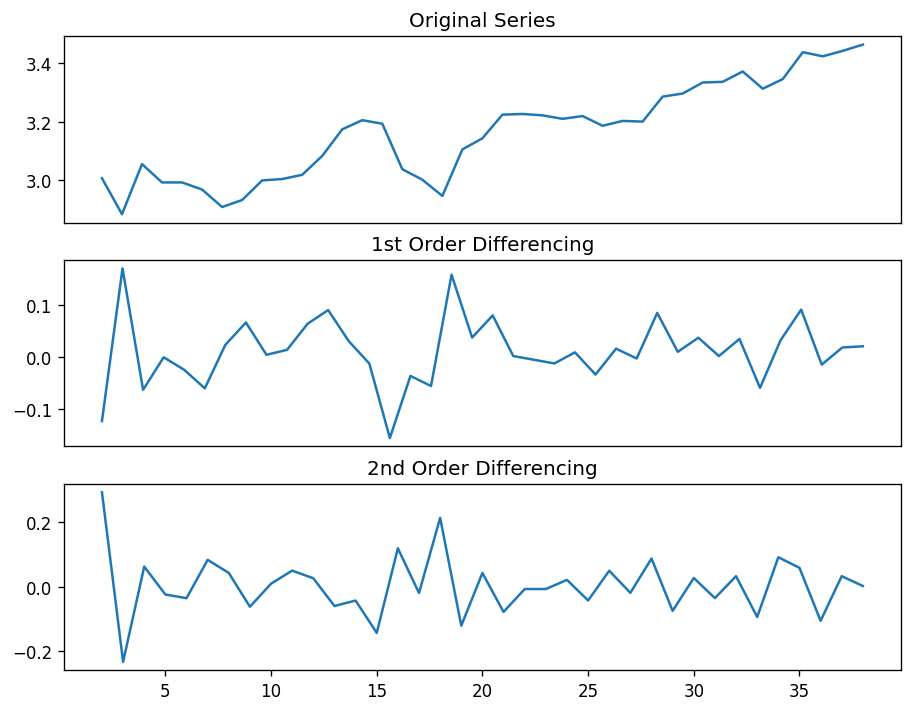

In [198]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(df_sample.microbusiness_density); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(df_sample.microbusiness_density.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(df_sample.microbusiness_density.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

The first order and second differencing shows noise components

We will investigate Ensemble Models with feature engineering as a high-risk solution to overcome the computation drawback w.r.t training 3000+ models we saw in this approach.